In [1]:
from collections import Counter

import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchinfo import summary
from torchmetrics.functional.image.ssim import structural_similarity_index_measure as ssim_func
from nn_zoo.datamodules import CIFARDataModule
from nn_zoo.models.components import DepthwiseSeparableConv2d, SelfAttention
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
class RandomMask:
    def __init__(self, patch_size):
        self.patch_size = (patch_size, patch_size)
        

    def __call__(self, x):
        start_pos = torch.randint(0, x.shape[-1] - self.patch_size[0], (2,), device=x.device)
        x[:, start_pos[0]:start_pos[0] + self.patch_size[0], start_pos[1]:start_pos[1] + self.patch_size[1]] = 0
        return x

dm = CIFARDataModule(
        data_dir="data",
        dataset_params={
            "download": True,
            "transform": torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize((32, 32)),
                    torchvision.transforms.ToTensor(),
                ]
            )
        },
        loader_params={
            "batch_size": 128,
        },
    )

dm.setup()

train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

100%|██████████| 170498071/170498071 [00:06<00:00, 28376964.89it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified


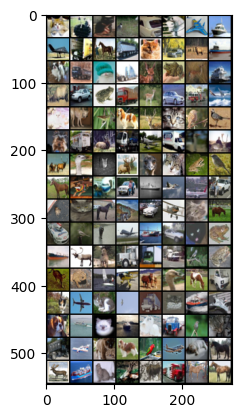

In [4]:
x, y = next(iter(train_loader))
grid = torchvision.utils.make_grid(x, nrow=8)
plt.imshow(grid.permute(1, 2, 0))

In [5]:
class Block(nn.Module):
    def __init__(self, in_channels:int, out_channels:int, kernel_size:int=3, stride:int=1, padding:int=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = DepthwiseSeparableConv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.act = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.bn(x)
        x = self.conv(x)
        x = self.act(x)
        return x


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            Block(3, 2),
            nn.MaxPool2d(2),
            Block(2, 4),
            nn.MaxPool2d(2),
            Block(4, 8),
            nn.MaxPool2d(2),
            Block(8, 16),
        )
        self.decoder = nn.Sequential(
            Block(16, 8),
            nn.Upsample(scale_factor=2),
            Block(8, 4),
            nn.Upsample(scale_factor=2),
            Block(4, 2),
            nn.Upsample(scale_factor=2),
            Block(2, 3),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = Model()
summary(model, input_size=(1, 3, 32, 32), depth=2)

Layer (type:depth-idx)                             Output Shape              Param #
Model                                              [1, 3, 32, 32]            --
├─Sequential: 1-1                                  [1, 16, 4, 4]             --
│    └─Block: 2-1                                  [1, 2, 32, 32]            44
│    └─MaxPool2d: 2-2                              [1, 2, 16, 16]            --
│    └─Block: 2-3                                  [1, 4, 16, 16]            36
│    └─MaxPool2d: 2-4                              [1, 4, 8, 8]              --
│    └─Block: 2-5                                  [1, 8, 8, 8]              88
│    └─MaxPool2d: 2-6                              [1, 8, 4, 4]              --
│    └─Block: 2-7                                  [1, 16, 4, 4]             240
├─Sequential: 1-2                                  [1, 3, 32, 32]            --
│    └─Block: 2-8                                  [1, 8, 4, 4]              328
│    └─Upsample: 2-9             

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.to("mps")

RuntimeError: PyTorch is not linked with support for mps devices

In [7]:
masker = RandomMask(8)

masked_x = masker(x)

In [15]:
masker = RandomMask(8)

val_loss = 0
val_ssim = 0
for epoch in range(10):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}", ncols=150)
    for x, y in pbar:
        x = x.to("mps")
        y = y.to("mps")
        optimizer.zero_grad()
        y_hat = model(x)
        loss = F.binary_cross_entropy(y_hat, x)
        loss.backward()
        optimizer.step()
        pbar.set_postfix_str(f"train_loss: {loss.item():.4f}, val_loss: {val_loss:.4f}, val_ssim: {val_ssim:.4f}")

    model.eval()
    val_ssim = 0
    val_loss = 0
    for x, y in val_loader:
        x = x.to("mps")
        y = y.to("mps")
        y_hat = model(x)
        val_loss += F.binary_cross_entropy(y_hat, x).item()
        val_ssim += ssim_func(y_hat, x).item()
    val_loss /= len(val_loader)
    val_ssim /= len(val_loader)

Epoch 9: 100%|██████████████████████████████████████████████| 391/391 [00:10<00:00, 37.39it/s, train_loss: 0.6662, val_loss: 0.6611, val_ssim: 0.2300]


In [ ]:
# plot reconstruction
y_hat = model(x)
plt.subplot(1, 3, 1)
plt.imshow(y_hat[0].detach().cpu().squeeze(), cmap="gray")
plt.axis("off")
plt.title("Reconstructed")

plt.subplot(1, 3, 2)
plt.imshow(x[0].detach().cpu().squeeze(), cmap="gray")
plt.axis("off")
plt.title("Original")

plt.subplot(1, 3, 3)
plt.imshow((y_hat[0] - x[0]).detach().cpu().squeeze(), cmap="gray")
plt.axis("off")
plt.title("Difference")

plt.show()

In [ ]:
(y_hat[0] - x[0]).detach().cpu().squeeze()